In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import cptac
import cptac.algorithms as al

In [2]:
def get_missence_truncation_comparison(cancer_object, specific_omics, gene):
    specific_omics = cancer_object.get_proteomics()
    #get omics data and tumors
    omics_and_mutations = cancer_object.append_mutations_to_omics(
                mutation_genes = gene, omics_df_name = specific_omics.name, omics_genes = gene).dropna()
    tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor']
    if omics_and_mutations[gene+"_"+specific_omics.name].empty:
        print('Not possible to do T-test. No data for', gene, 'in', specific_omics.name)
        return None
    else:
        somatic_mutations = cancer_object.get_mutations().reset_index()

        if cancer_object.get_cancer_type() == 'colon':
            missence_truncation_groups = {'frameshift substitution': 'T', 
                'frameshift deletion': 'T', 'frameshift insertion': 'T', 
                'stopgain': 'T', 'stoploss': 'T', 'nonsynonymous SNV': 'M',
                'nonframeshift insertion': 'M','nonframeshift deletion': 'M', 
                'nonframeshift substitution': 'M'}
        else: 
            missence_truncation_groups = {'In_Frame_Del': 'M', 'In_Frame_Ins': 'M',
                'Missense_Mutation': 'M', 'Frame_Shift_Del': 'T','Nonsense_Mutation': 'T', 
                'Splice_Site': 'T', 'Frame_Shift_Ins': 'T','Nonstop_Mutation':'T'}

        mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
        mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

        # group mutation categories
        miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'M']
        trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'T']

        #get lists of unique samples for missence and trucation categories
        miss_unique_samples = list(miss['Sample_ID'].unique())
        trunc_unique_samples = list(trunc['Sample_ID'].unique())

        #check if there is only one type of mutation for the specific gene
        if miss_unique_samples == []:
            print('Only truncation type mutations found for', gene+'.', 
                 'Not possible to compare mutation types.')
            return None
        elif trunc_unique_samples == []:
            print('Only missence type mutations found for', gene+'.', 
                 'Not possible to compare mutation types.')
            return None

        # Step 2 - Create the binary column needed to do the comparison
        # Get mutation catagories with omics data
        missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
        missence_omics = missence_omics.assign(binary_mutations = 'Missence')
        truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
        truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
        binary_mut_omics = missence_omics.append(truncation_omics)

        # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

        # Make a list of the column label of omics to be used in the wrap_ttest function
        omics_col_list = [binary_mut_omics.columns[0]] 

        # Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
        print("Doing t-test comparison\n")
        significant_pval_results = al.wrap_ttest(binary_mut_omics, 'binary_mutations', omics_col_list)
        #print(significant_pval_results)

        formated_data_for_boxplot = {'data': binary_mut_omics, 'x': "binary_mutations", 
                                     'y': gene+"_"+specific_omics.name, 'pval': significant_pval_results}
        return formated_data_for_boxplot


In [3]:
c_object = cptac.Colon()
omics = c_object.get_proteomics()

Doing t-test comparison



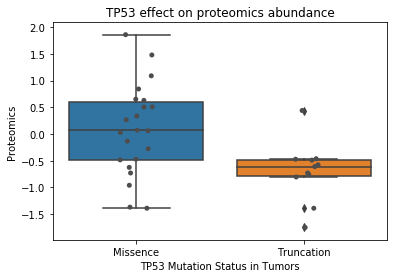

In [14]:
gene = 'TP53'
mutation_type_comparison = get_missence_truncation_comparison(c_object, omics, gene)
#print(mutation_type_comparison['pval'])

if mutation_type_comparison is not None:
    cis_boxplot = sns.boxplot(data = mutation_type_comparison['data'], x = mutation_type_comparison['x'],
                              y = mutation_type_comparison['y'], order = ["Missence","Truncation"])  
    cis_boxplot.set_title(gene + " effect on " + omics.name + " abundance")
    cis_boxplot = sns.stripplot(
        data = mutation_type_comparison['data'], x = mutation_type_comparison['x'],y = mutation_type_comparison['y'], 
        jitter = True, color = ".3", order = ["Missence","Truncation"]) 
    cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
    plt.show()


In [15]:
print(len(mutation_type_comparison['data']))
mutation_type_comparison['data']

33


,TP53_proteomics,binary_mutations
Sample_ID,,
S005,-1.3900,Missence
S021,-0.4840,Missence
S026,0.3360,Missence
S030,-0.4720,Missence
S031,-0.1340,Missence
S032,1.4800,Missence
S039,-1.3700,Missence
S046,0.8430,Missence
S049,0.0611,Missence


In [89]:
m = c_object.get_mutations()
m.loc[m['Gene'] == 'TP53']

,Gene,Mutation,Location
Sample_ID,,,
S001,TP53,Missense_Mutation,p.R248W
S006,TP53,Missense_Mutation,p.S241C
S008,TP53,Missense_Mutation,p.S127Y
S009,TP53,Nonsense_Mutation,p.R196*
S016,TP53,Missense_Mutation,p.K164E
S020,TP53,Missense_Mutation,p.G244D
S022,TP53,Nonsense_Mutation,p.R213*
S031,TP53,In_Frame_Del,p.S241del
S041,TP53,Nonsense_Mutation,p.W146*


In [92]:
gene = 'TP53'
omics_and_mutations = en_object.append_mutations_to_omics(
                mutation_genes = gene, omics_df_name = omics.name, omics_genes = gene).dropna()
tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor']

In [94]:
tumors.loc[tumors['TP53_Mutation_Status'] != 'Wildtype_Tumor']

,TP53_proteomics,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status
Sample_ID,,,,,
S001,0.2950,[Missense_Mutation],[p.R248W],Single_mutation,Tumor
S006,3.0100,[Missense_Mutation],[p.S241C],Single_mutation,Tumor
S008,0.4410,[Missense_Mutation],[p.S127Y],Single_mutation,Tumor
S009,-1.2200,[Nonsense_Mutation],[p.R196*],Single_mutation,Tumor
S016,2.1200,[Missense_Mutation],[p.K164E],Single_mutation,Tumor
S020,0.3530,[Missense_Mutation],[p.G244D],Single_mutation,Tumor
S022,-0.1540,[Nonsense_Mutation],[p.R213*],Single_mutation,Tumor
S031,1.5600,[In_Frame_Del],[p.S241del],Single_mutation,Tumor
S042,-0.1860,[Frame_Shift_Ins],[p.V217Wfs*31],Single_mutation,Tumor
